In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import sys
import argparse
import glob
import multiprocessing as mp
import os
import time

import cv2
import numpy as np
import pandas as pd
import tqdm
import math

from detectron2.data.detection_utils import read_image
from detectron2.utils.logger import setup_logger

from demo.predictor import VisualizationDemo
from adet.config import get_cfg


from scipy import ndimage
from scipy import ndimage as ndi 

from PIL import Image
from skimage import io, color, measure, filters
from skimage.morphology import binary_dilation, disk, binary_erosion, convex_hull_image, remove_small_objects, erosion, remove_small_holes, dilation
from skimage.measure import regionprops, label
from skimage.segmentation import clear_border, active_contour
from skimage.transform import rotate, hough_circle, hough_circle_peaks, rescale, resize
from skimage import draw

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import re

c:\Users\win\anaconda3\envs\nematode2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# constants
WINDOW_NAME = "COCO detections"

mp.set_start_method("spawn", force=True)

In [3]:
# define the config function

def setup_cfg(model_config_file, model_opts, confidence_threshold):
    cfg = get_cfg()
    cfg.merge_from_file(model_config_file)
    cfg.merge_from_list(["MODEL.WEIGHTS", model_opts])
    cfg.MODEL.RETINANET.SCORE_THRESH_TEST = confidence_threshold
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = confidence_threshold
    cfg.MODEL.FCOS.INFERENCE_TH_TEST = confidence_threshold
    cfg.MODEL.MEInst.INFERENCE_TH_TEST = confidence_threshold
    cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = confidence_threshold
    cfg.freeze()

    return cfg


In [6]:
# read the binary image

binary_img_path = r'test\binary_mask.png'

dst_binary_img=cv2.imread(binary_img_path, -1)
shape = dst_binary_img.shape
cols=shape[1]
rows=shape[0]
num_of_cols=4    
num_of_rows=3   

In [13]:
# import the config file

model_config_file = r'training_dir\config.yaml'
model_opts = r'training_dir\model_final.pth'
confidence_threshold = 0.3
cfg = setup_cfg(model_config_file, model_opts, confidence_threshold)

In [8]:
demo = VisualizationDemo(cfg)

In [19]:
img_path = r"test\cropped_image.png"
img = read_image(img_path, format="BGR")

start_time = time.time()
instances, predictions, visualized_output = demo.run_on_image(img)

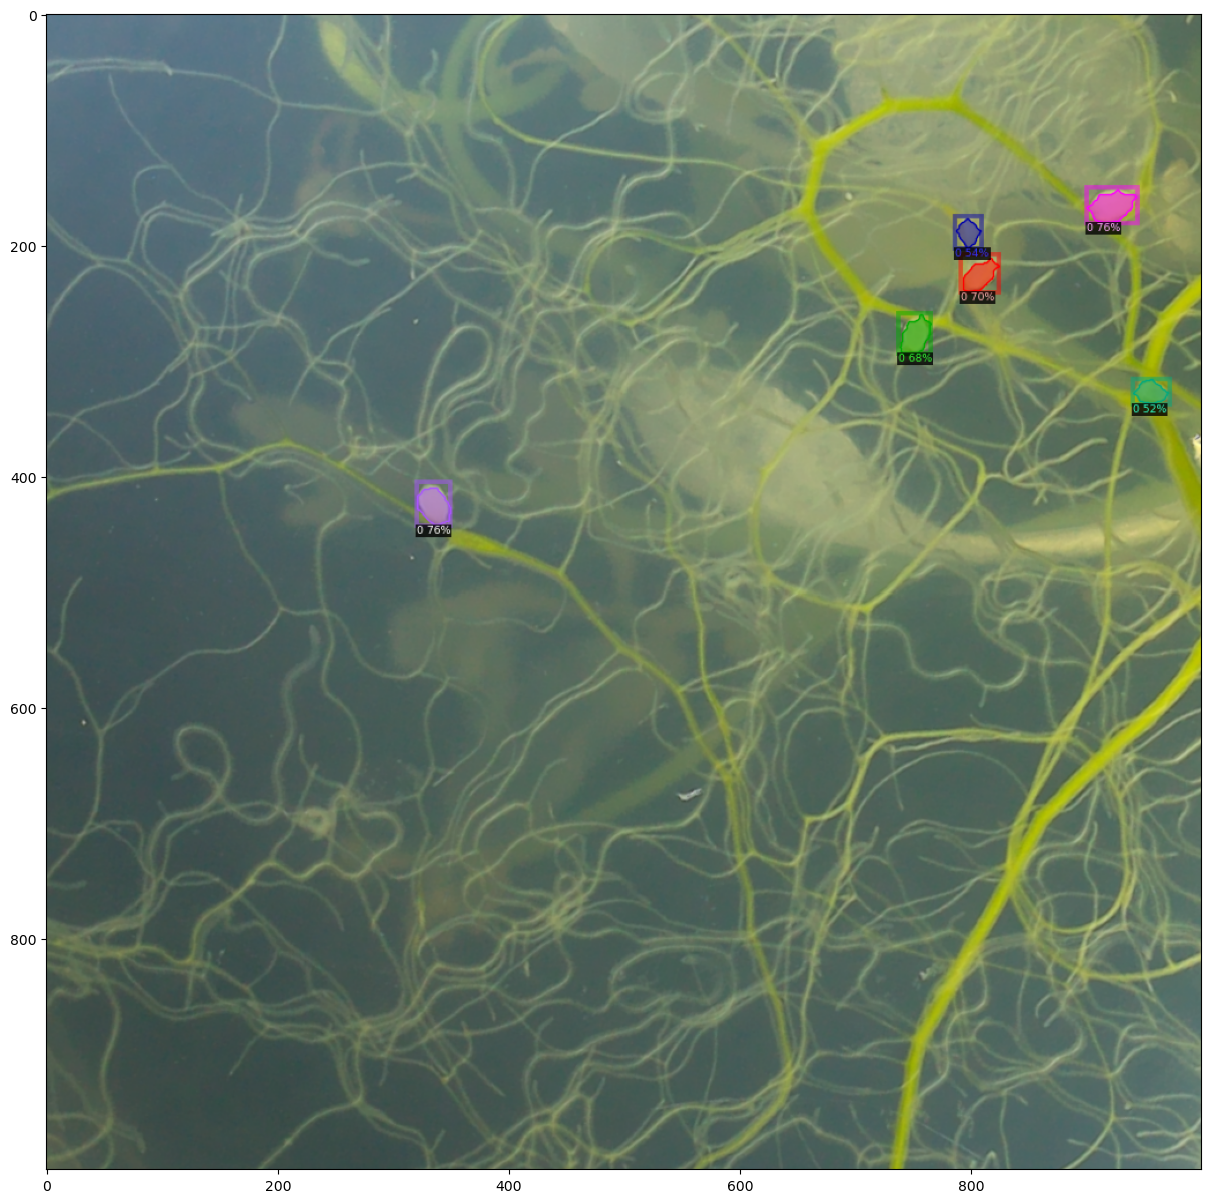

In [14]:
# visualize the output

fig, ax = plt.subplots(figsize=(15, 15))
if hasattr(visualized_output, 'get_image'):
    img_array = visualized_output.get_image()
    ax.imshow(img_array)
else:
    # Fallback if it's already an array
    ax.imshow(visualized_output)

plt.show()

100%|██████████| 12/12 [00:01<00:00,  6.89it/s]


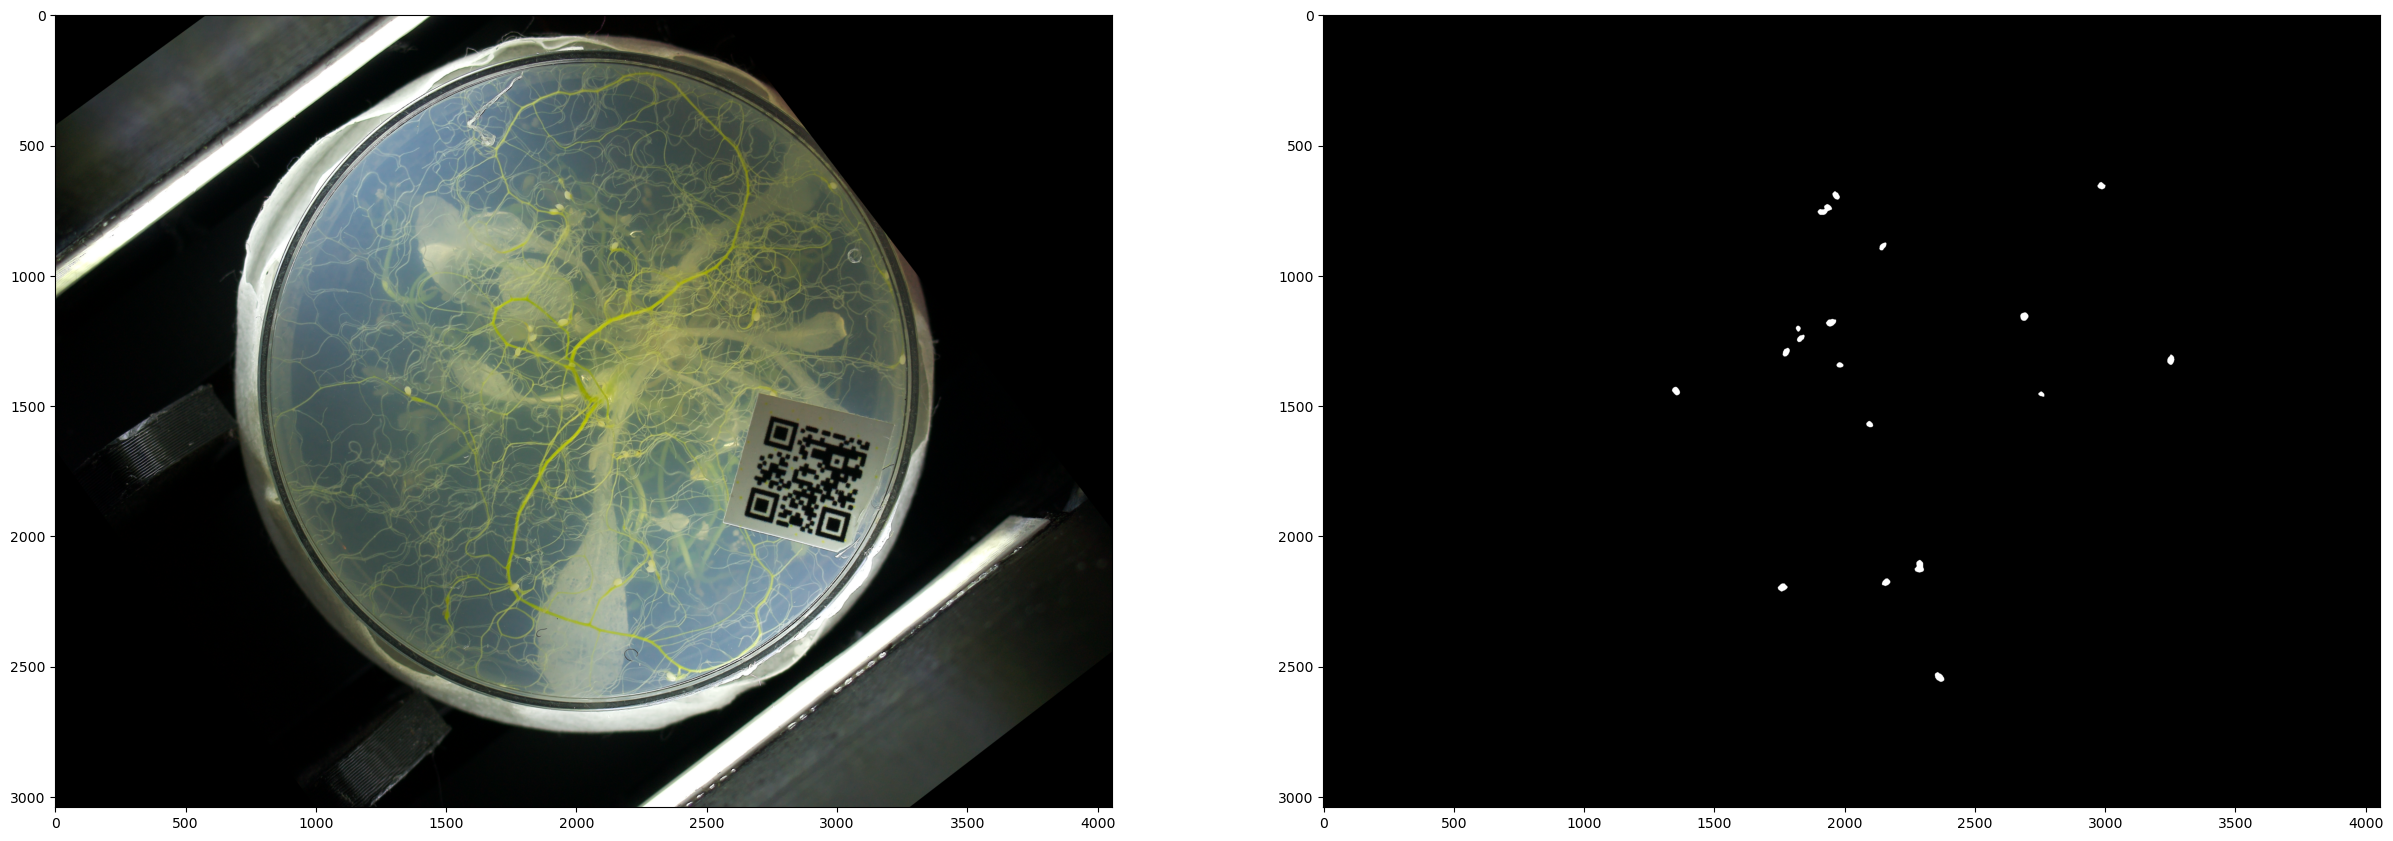

In [21]:
# analyse the test image then vislialize the output

get_input_path  = r'test\Line452_rep01_2022-05-12_08_53_41.944052_Lilo'

if os.path.isdir(get_input_path):
    input_path = [os.path.join(get_input_path, fname) for fname in os.listdir(get_input_path)]

dst = np.zeros((rows*num_of_rows,cols*num_of_cols),np.uint8)

for path in tqdm.tqdm(input_path):

    img = read_image(path, format="BGR")
    start_time = time.time()

    instances, predictions, visualized_output = demo.run_on_image(img)
    output = predictions["instances"]

    mask_result = np.zeros((1000, 1000), dtype=np.uint8)
    mask = np.zeros((1000, 1000), dtype=np.uint8)
    # 新建一个空的list，用于存储每个线虫蒙版的bbox
    for i in range(len(output)):

        mask_add = output.pred_masks[i].cpu().numpy().astype("uint8") # 每个线虫的蒙版
        mask_result = np.logical_or(mask_result, mask_add)
        mask_result = mask_result.astype(np.uint8)
        mask = cv2.GaussianBlur(mask_result, (0,0), sigmaX=3, sigmaY=3, borderType = cv2.BORDER_DEFAULT)
        mask = mask.astype(bool)
    
    cols_th = int(path.split("_")[-1].split('.')[0])
    rows_th = int(path.split("_")[-2])
    
    roi = mask[0:rows,0:cols]
    dst[rows_th*rows:(rows_th+1)*rows,cols_th*cols:(cols_th+1)*cols] = roi

new_width = 4056
new_height = 3040

dst = dst.astype(np.uint8)
dst_PT_mask = cv2.resize(dst, (new_width, new_height), interpolation=cv2.INTER_AREA)

input_img = io.imread(r'test\Line452_rep01_2022-05-12_08_53_41.944052_Lilo.png')

fig, ax = plt.subplots(1,2,figsize=(30, 30))
ax[0].imshow(input_img)
ax[1].imshow(dst_PT_mask, cmap='gray')
plt.show()